In [ ]:
%pip install folium
%pip install geopandas
%pip install xgboost
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### 🧷☘️ mini Project

 > 서울시 부동산 실거래가 데이터를 분석하여 층수에 따른 거래 금액 차이를 비교하고 예측하는 작업

### **🔥 프로젝트 개요**

✅ **목표:**

- 서울시 **자치구/법정동 단위로 범죄 발생 데이터를 분석**하여 위험 지역을 식별
- 머신러닝 모델을 활용해 **범죄 발생 예측**
- 웹 서비스로 **사용자가 자신의 위치에서 위험도(안전도도)를 확인**

✅ **활용할 데이터:**

- 서울시 열린데이터광장의 **범죄 발생 데이터 (예: 절도, 폭행, 강도, 성범죄 등)**
- 경찰청/통계청 데이터 (치안시설, CCTV 개수 등)
- 추가적으로 **날씨, 시간대, 유동 인구** 등의 변수도 고려 가능

✅ **예상 기술 스택:**

- **데이터 수집:** `requests` (API) + `pandas` (파일처리)
- **DB 저장:** MongoDB
- **분석 및 모델링:** `scikit-learn` (랜덤포레스트, 로지스틱 회귀 등)
- **시각화:** `Matplotlib`, `Seaborn`, `Folium` (지도 시각화)
- **웹 서비스:** `Flask` + `Plotly/Dash` (대시보드)

### 1️⃣ 데이터 수집 및 로드

* 필요한 라이브러리 설치

In [50]:
import pandas as pd
import requests

* 필요한 데이터 수집 - 서울시 부동산, cctv, 5대범죄, 경찰서 (head 부분만 보여줌)

In [51]:
# 데이터 파일 경로 (예: CSV 파일 로드)
file_path = '서울시 부동산 실거래가 정보(2022~2025).csv'

# CSV 파일을 Pandas 데이터프레임으로 로드
data = pd.read_csv(file_path, encoding='euc-kr')

# 데이터 확인
# print(data.head())

data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_50144\742582261.py:5: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding='euc-kr')


,접수연도,자치구코드,자치구명,법정동코드,법정동명,지번구분,지번구분명,본번,부번,건물명,...,물건금액(만원),건물면적(㎡),토지면적(㎡),층,권리구분,취소일,건축년도,건물용도,신고구분,신고한 개업공인중개사 시군구명
0,2025,11320,도봉구,10600,방학동,1.0,대지,638.0,10.0,한신빌라(638-10),...,14800,37.66,16.00,4.0,NaN,NaN,1994.0,연립다세대,중개거래,서울 도봉구
1,2025,11380,은평구,10800,역촌동,NaN,NaN,NaN,NaN,NaN,...,39620,74.08,182.00,NaN,NaN,NaN,1972.0,단독다가구,직거래,NaN
2,2025,11500,강서구,10200,등촌동,1.0,대지,628.0,13.0,현대프린스텔,...,10300,26.16,35.71,6.0,NaN,NaN,1999.0,오피스텔,중개거래,서울 강서구
3,2025,11620,관악구,10200,신림동,1.0,대지,1639.0,51.0,푸리마타운,...,12700,18.70,26.16,8.0,NaN,NaN,2014.0,오피스텔,중개거래,서울 관악구
4,2025,11530,구로구,10600,고척동,1.0,대지,339.0,0.0,고척파크푸르지오,...,84000,59.89,0.00,9.0,NaN,NaN,2009.0,아파트,중개거래,"서울 구로구, 서울 양천구"


In [86]:
# 부동산 실거래가 데이터 로드 (CSV 파일)
real_estate_file = '서울시 부동산 실거래가 정보(2022~2025).csv'
real_estate_data = pd.read_csv(real_estate_file, encoding='euc-kr')

# 필요한 컬럼 선택 (예: 자치구명, 법정동명, 계약일, 물건금액(만원), 건물면적(㎡), 층, 건축년도)
real_estate_data = real_estate_data[['자치구명', '법정동명', '계약일', '물건금액(만원)', '건물면적(㎡)', '층', '건축년도']]

real_estate_data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_50144\3636665340.py:3: DtypeWarning:

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.



,자치구명,법정동명,계약일,물건금액(만원),건물면적(㎡),층,건축년도
0,도봉구,방학동,20250117,14800,37.66,4.0,1994.0
1,은평구,역촌동,20250117,39620,74.08,NaN,1972.0
2,강서구,등촌동,20250117,10300,26.16,6.0,1999.0
3,관악구,신림동,20250117,12700,18.70,8.0,2014.0
4,구로구,고척동,20250117,84000,59.89,9.0,2009.0


In [53]:
# CCTV 데이터 로드 (CSV 파일 예시)
cctv_file = '서울시 자치구cctv.csv'  # 파일 이름 (실제 파일명을 사용)
cctv_data = pd.read_csv(cctv_file,  encoding='utf-8')  # 파일 인코딩에 맞게 지정

# 예시 데이터 프레임 구조 확인
cctv_data.head()


,자치구,CCTV_총계
0,종로구,2339
1,중구,3118
2,용산구,3609
3,성동구,4638
4,광진구,4636


In [54]:
# 범죄 발생현황 데이터 로드 (CSV 파일 예시)
crime_file = '서울시 5대범죄발생.csv'
crime_data = pd.read_csv(crime_file, encoding='utf-8', sep='\t')  # 파일 인코딩에 맞게 지정

# 데이터 구조 확인 (예: 자치구별(1), 자치구별(2), 각 범죄 발생 건수 등)
crime_data.head()

,자치구,살인,강도,강간·강제추행,절도,폭력,범죄_합계
0,종로구,5,5,239,1169,1563,2981
1,중구,3,6,212,1520,1607,3348
2,용산구,3,3,245,978,1792,3021
3,성동구,2,2,119,893,1007,2023
4,광진구,2,5,238,1616,1563,3424


In [55]:
# 파출소, 지구대 데이터 로드 (csv 파일 예시)
police_file = '서울시 경찰청.csv'
police_data = pd.read_csv(police_file, encoding='euc-kr')

police_data.head()

,연번,시도청,경찰서,관서명,구분,전화번호,주소
0,1,서울청,서울중부,을지,지구대,02-2279-1908,서울특별시 중구 을지로 234
1,2,서울청,서울중부,광희,지구대,02-2233-1444,서울특별시 중구 퇴계로 375-1
2,3,서울청,서울중부,약수,지구대,02-2234-8112,"서울특별시 중구 동호로 5길 15, 약수지구대"
3,4,서울청,서울중부,신당,파출소,02-2252-0435,"서울특별시 중구 다산로 248 (신당동, 신당파출소)"
4,5,서울청,서울중부,장충,파출소,02-2274-9003,서울특별시 중구 동호로 261


In [59]:
# 파출소, 지구대 데이터 로드 (csv 파일 예시)
police_file = '서울시 경찰청.csv'
police_data = pd.read_csv(police_file, encoding='euc-kr')

# '시도청' 컬럼에서 '서울청'인 데이터만 필터링
seoul_data = police_data[police_data['시도청'] == '서울청']

seoul_data

,연번,시도청,경찰서,관서명,구분,전화번호,주소
0,1,서울청,서울중부,을지,지구대,02-2279-1908,서울특별시 중구 을지로 234
1,2,서울청,서울중부,광희,지구대,02-2233-1444,서울특별시 중구 퇴계로 375-1
2,3,서울청,서울중부,약수,지구대,02-2234-8112,"서울특별시 중구 동호로 5길 15, 약수지구대"
3,4,서울청,서울중부,신당,파출소,02-2252-0435,"서울특별시 중구 다산로 248 (신당동, 신당파출소)"
4,5,서울청,서울중부,장충,파출소,02-2274-9003,서울특별시 중구 동호로 261
...,...,...,...,...,...,...,...
238,239,서울청,서울수서,대치,지구대,02-538-1312,서울특별시 강남구 삼성로 203
239,240,서울청,서울수서,수서,파출소,02-445-0112,서울특별시 강남구 밤고개로1길 48
240,241,서울청,서울수서,대왕,파출소,02-3411-0323,서울특별시 강남구 헌릉로 623
241,242,서울청,서울수서,일원,지구대,02-3411-0112,서울특별시 강남구 일원로3길 35 일원파출소


### 2️⃣ 데이터 전처리 및 정리

✅ **필요한 작업**  - 필요한 컬럼정리 & 데이터 병합
- 부동산 실거래가 데이터에서 자치구별 평균 거래 금액 계산  
- 범죄 데이터에서 자치구별 총 범죄 발생 건수 정리  
- CCTV 데이터에서 자치구별 CCTV 개수 정리  
- 치안 시설 데이터에서 차안시설 개수 정리
- 데이터셋 간 컬럼명 통일 (자치구 기준)

In [56]:
# 부동산 실거래가 데이터 로드 (CSV 파일)
real_estate_file = '서울시 부동산 실거래가 정보(2022~2025).csv'
real_estate_data = pd.read_csv(real_estate_file, encoding='euc-kr')

# 필요한 컬럼 선택 (예: 자치구명, 법정동명, 계약일, 물건금액(만원), 건물면적(㎡), 층, 건축년도)
real_estate_data = real_estate_data[['자치구명', '법정동명', '계약일', '물건금액(만원)', '건물면적(㎡)', '층', '건축년도']]

# 자치구명을 기준으로 분석할 것이므로, 컬럼명을 '자치구'로 재설정
real_estate_data.rename(columns={'자치구명': '자치구'}, inplace=True)

# 🔹 자치구별 평균 거래금액, 건물 면적, 건축년도 평균 산출
real_estate_grouped_data = real_estate_data.groupby('자치구').agg({
    '물건금액(만원)': 'mean',
    '건물면적(㎡)': 'mean',
    '건축년도': 'mean'
}).reset_index()

# 🔹 컬럼명 변경
real_estate_grouped_data.rename(columns={
    '물건금액(만원)': '평균거래금액',
    '건물면적(㎡)': '평균건물면적',
    '건축년도': '평균건축년도'
}, inplace=True)

# 결과 확인
real_estate_grouped_data


C:\Users\user\AppData\Local\Temp\ipykernel_50144\572502328.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate_data = pd.read_csv(real_estate_file, encoding='euc-kr')


,자치구,평균거래금액,평균건물면적,평균건축년도
0,강남구,175249.427417,79.076040,1969.486368
1,강동구,74539.098009,62.631046,1950.334511
2,강북구,36790.413714,59.379247,1989.167861
3,강서구,41237.221077,50.553006,2007.690953
4,관악구,48789.376776,66.181239,1998.160375
5,광진구,74112.636846,69.432226,1980.390351
6,구로구,43640.239348,57.414521,2003.107029
7,금천구,37890.772739,52.108477,2012.116243
8,노원구,55159.558606,62.006903,1994.416388
9,도봉구,38065.337139,62.258850,1999.531868


In [57]:
# CCTV 데이터 로드 (CSV 파일)
cctv_file = '서울시 자치구cctv.csv'
cctv_data = pd.read_csv(cctv_file, encoding='utf-8-sig')
# 파일의 컬럼은 이미 '자치구'와 'CCTV_총계'로 구성되어 있음

# 결과 확인
cctv_data


,자치구,CCTV_총계
0,종로구,2339
1,중구,3118
2,용산구,3609
3,성동구,4638
4,광진구,4636
5,동대문구,3846
6,중랑구,5392
7,성북구,4906
8,강북구,3584
9,도봉구,2808


In [58]:
# 범죄 발생현황 데이터 로드 (CSV 파일 예시)
crime_file = '서울시 5대범죄발생.csv'
crime_data = pd.read_csv(crime_file, encoding='utf-8', sep='\t')  # 파일 인코딩에 맞게 지정

crime_data = crime_data[['자치구', '범죄_합계']]
# 데이터 구조 확인 (예: 자치구별(1), 자치구별(2), 각 범죄 발생 건수 등)
crime_data

,자치구,범죄_합계
0,종로구,2981
1,중구,3348
2,용산구,3021
3,성동구,2023
4,광진구,3424
5,동대문구,2957
6,중랑구,3324
7,성북구,2411
8,강북구,2497
9,도봉구,1921


In [60]:
# '시도청' 컬럼에서 '서울청'인 데이터만 필터링
seoul_data = police_data[police_data['시도청'] == '서울청']

# 주소에서 구 이름 추출 (예: '서울특별시 중구 을지로 234' → '중구')
seoul_data['구'] = seoul_data['주소'].str.split().str[1]

# 구별 개수 세기
gu_data = seoul_data['구'].value_counts().reset_index()
gu_data.columns = ['자치구', '치안시설_합계']

# 결과 출력
gu_data

C:\Users\user\AppData\Local\Temp\ipykernel_50144\1772231041.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seoul_data['구'] = seoul_data['주소'].str.split().str[1]


,자치구,치안시설_합계
0,종로구,20
1,중구,15
2,강남구,14
3,송파구,11
4,서초구,11
5,동대문구,11
6,성북구,10
7,영등포구,10
8,강서구,10
9,광진구,10


* 데이터 행 뽑아보기

In [61]:
cctv_data.columns

Index(['자치구', 'CCTV_총계'], dtype='object')

In [62]:
real_estate_data.columns

Index(['자치구', '법정동명', '계약일', '물건금액(만원)', '건물면적(㎡)', '층', '건축년도'], dtype='object')

In [63]:
crime_data.columns

Index(['자치구', '범죄_합계'], dtype='object')

In [87]:
police_data.columns

Index(['구', '개수'], dtype='object')

> 📌 자치구 기준 데이터 병합 - 데이터 셋 간 컬럼 명 통일 자치구 맞춤

In [64]:
# 데이터 병합 (자치구 기준)
merged_data = crime_data.merge(cctv_data, on='자치구').merge(real_estate_grouped_data, on='자치구').merge(gu_data, on='자치구')

# 🔹 위험도 계산 (총범죄발생 / CCTV 개수)
merged_data["위험도"] = merged_data["범죄_합계"] / (merged_data["CCTV_총계"] + 1)

In [65]:
merged_data

,자치구,범죄_합계,CCTV_총계,평균거래금액,평균건물면적,평균건축년도,치안시설_합계,위험도
0,종로구,2981,2339,70475.616528,69.724773,2001.131785,20,1.273932
1,중구,3348,3118,75016.632878,63.949920,1979.071470,15,1.073421
2,용산구,3021,3609,159554.119372,83.948502,1998.813546,7,0.836842
3,성동구,2023,4638,122804.979214,75.698076,1994.117491,9,0.436085
4,광진구,3424,4636,74112.636846,69.432226,1980.390351,10,0.738408
5,동대문구,2957,3846,62288.451220,64.781042,1940.102780,11,0.768651
6,중랑구,3324,5392,45769.851034,60.654311,1999.330731,8,0.616355
7,성북구,2411,4906,64624.189311,72.747125,1995.559771,10,0.491339
8,강북구,2497,3584,36790.413714,59.379247,1989.167861,9,0.696513
9,도봉구,1921,2808,38065.337139,62.258850,1999.531868,8,0.683873


### 3️⃣ 데이터 분석 및 시각화

- 필요한 라이브러리 설치

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import folium
import pandas as pd
import plotly.express as px
import matplotlib.ticker as mticker

✅ **상관관계 분석**  

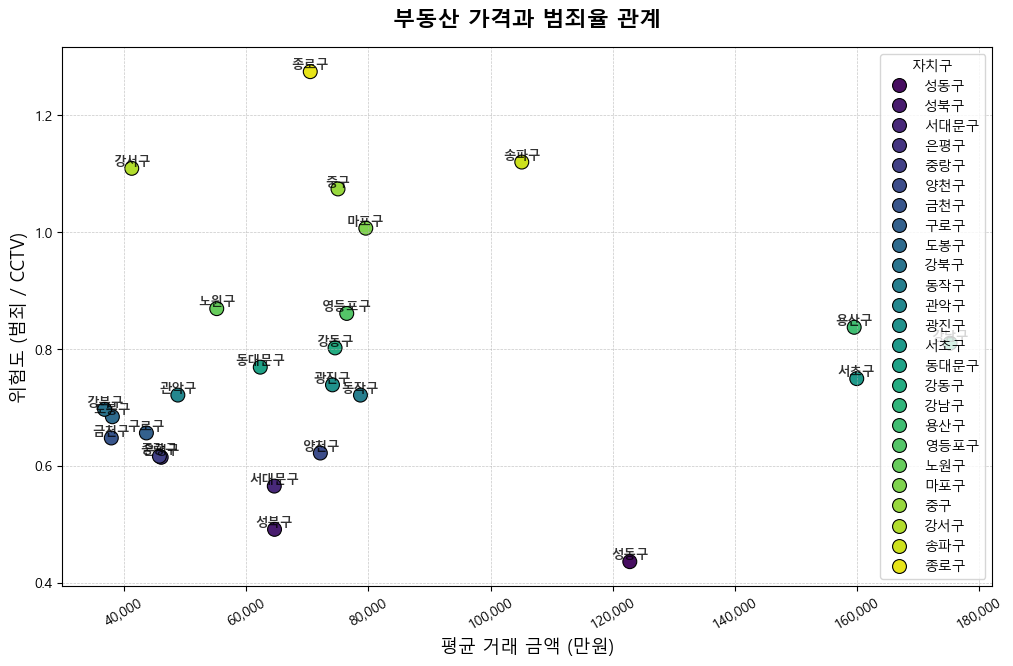

In [88]:
# 🔹 한글 폰트 설정 (Windows, Mac, Linux 지원)
import platform
if platform.system() == "Windows":
    plt.rc("font", family="Malgun Gothic")  # Windows
elif platform.system() == "Darwin":
    plt.rc("font", family="AppleGothic")  # Mac
else:
    plt.rc("font", family="NanumGothic")  # Linux

# 🔹 그래프 크기 설정
plt.figure(figsize=(12, 7))

# 🔹 산점도 플롯 (hue로 자치구별 색상 구분)
sns.scatterplot(x="평균거래금액", y="위험도", data=merged_data, hue="자치구", s=100, palette="viridis", edgecolor="black")

# 🔹 각 데이터 포인트 옆에 자치구 이름 표시 (겹치지 않도록 `ha="center"` 사용)
for i in range(len(merged_data)):
    plt.text(
        merged_data["평균거래금액"][i], merged_data["위험도"][i], merged_data["자치구"][i],
        fontsize=9, ha="center", va="bottom", fontweight="bold", color="black", alpha=0.8
    )

# 🔹 그래프 제목 및 라벨
plt.title("부동산 가격과 범죄율 관계", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("평균 거래 금액 (만원)", fontsize=13)
plt.ylabel("위험도 (범죄 / CCTV)", fontsize=13)

# 🔹 X축 라벨을 천 단위 콤마(,) 형식으로 표시하여 가독성 향상
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# 🔹 X축 라벨 회전 (가독성 향상)
plt.xticks(rotation=30)

# 🔹 그래프 테두리 스타일 개선
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# 🔹 그래프 표시
plt.show()


✅ **자치구별 위험도 바 차트**

##### 위험도(범죄 / CCTV)의 의미  

🔹 **공식:**  
$$
\text{위험도} = \frac{\text{총범죄발생 수}}{\text{CCTV 개수} + 1}
$$

- **총범죄발생 수**: 해당 자치구에서 1년 동안 발생한 범죄 총합  
- **CCTV 개수**: 해당 자치구의 공공 CCTV 설치 수  
- **+1을 추가한 이유**: 일부 지역에서 CCTV 개수가 0일 경우 무한대 오류 방지  

📌 **해석**  
- **위험도가 높을수록** → CCTV 1대당 감시해야 하는 범죄 수가 많아 **범죄 예방 효과가 낮음**  
- **위험도가 낮을수록** → CCTV 1대당 감시하는 범죄가 적어 **더 안전한 지역**으로 볼 수 있음  


C:\Users\user\AppData\Local\Temp\ipykernel_50144\2470667990.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="자치구", y="위험도", data=merged_data.sort_values(by="위험도", ascending=False), palette="Reds_r")


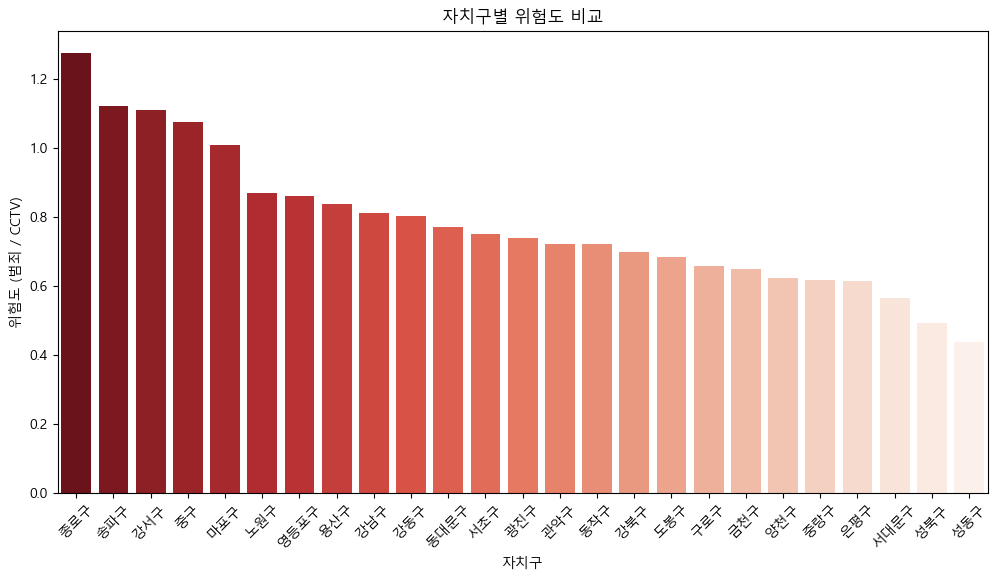

In [68]:
plt.figure(figsize=(12, 6))
sns.barplot(x="자치구", y="위험도", data=merged_data.sort_values(by="위험도", ascending=False), palette="Reds_r")
plt.xticks(rotation=45)
plt.title("자치구별 위험도 비교")
plt.xlabel("자치구")
plt.ylabel("위험도 (범죄 / CCTV)")
plt.show()

✅ **cctv 개수와 평균 거래 금액 비교 데이터 필터링**

- 주요 요소 : CCTV 개수, 평균 거래 금액, 버블 크기
- 사용 기술 : pandas, matpolotlib.pyplot, colorbar, text()
- 특징 : CCTV 개수와 평균 거래 금액 간의 관계 시각화

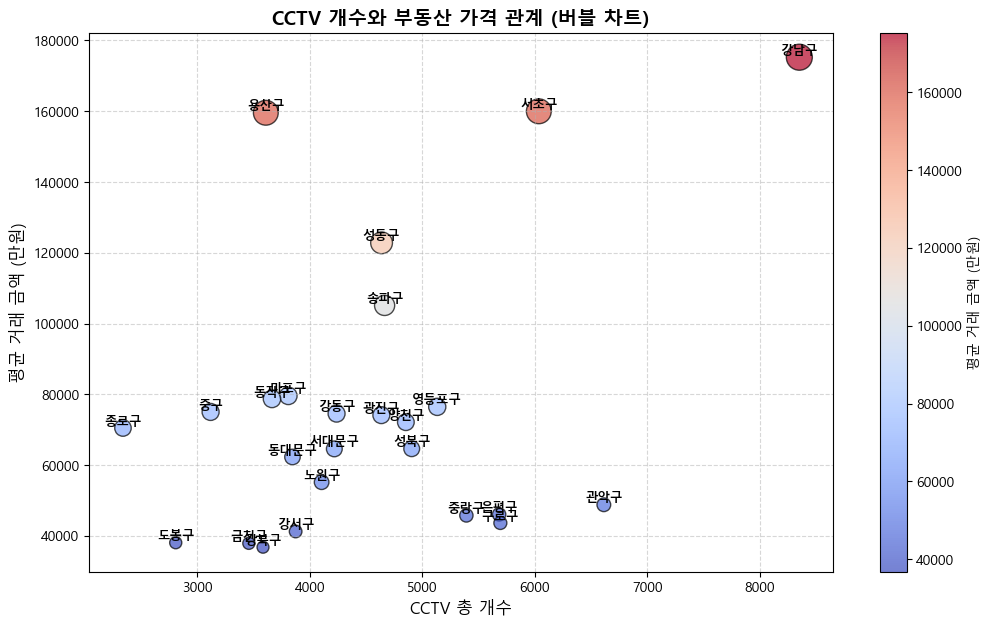

In [69]:
# 🔹 CCTV 개수와 평균 거래 금액 비교를 위한 데이터 필터링
cctv_vs_price = merged_data[["자치구", "CCTV_총계", "평균거래금액"]].dropna()

# 🔹 버블 차트 시각화 (CCTV 개수 vs 평균 거래 금액)
plt.figure(figsize=(12, 7))
bubble = plt.scatter(
    cctv_vs_price["CCTV_총계"],
    cctv_vs_price["평균거래금액"],
    s=cctv_vs_price["평균거래금액"] / 500,  # 버블 크기 조정 (부동산 가격에 비례)
    c=cctv_vs_price["평균거래금액"],
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="black"
)

# 🔹 각 데이터 포인트 옆에 자치구 이름 표시
for i in range(len(cctv_vs_price)):
    plt.text(
        cctv_vs_price["CCTV_총계"].iloc[i],
        cctv_vs_price["평균거래금액"].iloc[i],
        cctv_vs_price["자치구"].iloc[i],
        fontsize=9,
        ha="center",
        va="bottom",
        fontweight="bold"
    )

# 🔹 그래프 제목 및 라벨 설정
plt.title("CCTV 개수와 부동산 가격 관계 (버블 차트)", fontsize=14, fontweight="bold")
plt.xlabel("CCTV 총 개수", fontsize=12)
plt.ylabel("평균 거래 금액 (만원)", fontsize=12)

# 🔹 컬러 바 추가 (부동산 가격을 색상으로 표시)
cbar = plt.colorbar(bubble)
cbar.set_label("평균 거래 금액 (만원)")

# 🔹 그래프 표시
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


✅ **안전도 바차트**

- 주요 요소: CCTV 개수, 경찰서 개수, 범죄 발생 수
- 사용 기술: pandas(데이터 처리), plotly.express(시각화)
- 특징: 마우스를 올리면 데이터 확인 가능, 막대 위 점수 표시, 색상 변화로 직관적 비교 가능

In [70]:
# 🔹 안전도 점수 계산 (CCTV 개수 & 경찰서 개수 반영)
merged_data["안전도_점수"] = (merged_data["CCTV_총계"] + merged_data["치안시설_합계"]) / (merged_data["범죄_합계"] + 1)
merged_data["안전도_라벨"] = (merged_data["안전도_점수"] > merged_data["안전도_점수"].median()).astype(int)

# 🔹 안전도 점수를 내림차순 정렬
merged_data_sorted = merged_data.sort_values(by="안전도_점수", ascending=False)

# 🔹 Plotly 막대 그래프 생성
fig = px.bar(
    merged_data_sorted,
    x="자치구",
    y="안전도_점수",
    text="안전도_점수",
    title="📊 서울시 자치구별 안전도 점수 비교",
    color="안전도_점수",
    color_continuous_scale="Blues"
)

# 🔹 그래프 레이아웃 조정
fig.update_traces(texttemplate="%{text:.2f}", textposition="outside")
fig.update_layout(
    xaxis_title="자치구",
    yaxis_title="안전도 점수",
    xaxis=dict(tickangle=-45),  # X축 라벨 회전
    width=800,
    height=500
)

# 🔹 그래프 출력
fig.show()


✅ **3D 분석**

In [71]:
# 🔹 안전도 점수 계산 (CCTV 개수와 경찰서 개수를 고려)
merged_data["안전도_점수"] = (merged_data["CCTV_총계"] + merged_data["치안시설_합계"]) / (merged_data["범죄_합계"] + 1)

# 🔹 3D 산점도 그래프 생성 (X: 범죄율, Y: 부동산 가격, Z: 안전도)
fig = px.scatter_3d(
    merged_data,
    x="범죄_합계", 
    y="평균거래금액", 
    z="안전도_점수",
    color="평균거래금액",  # 색상을 부동산 가격으로 설정
    size="안전도_점수",  # 점의 크기를 안전도로 설정
    hover_name="자치구",
    title="📊 안전도, 부동산 가격, 범죄율 3D 분석",
    labels={"범죄_합계": "범죄율", "평균거래금액": "부동산 가격", "안전도_점수": "안전도 점수"}
)

# 🔹 그래프 표시
fig.show()


✅ **안전한 거주지 추천**

In [72]:
# 🔹 안전도 점수 = (CCTV + 파출소 개수) / (범죄 발생 수 + 1)  (※ 1 추가: 0으로 나눔 방지)
merged_data["안전도 점수"] = (merged_data["CCTV_총계"] + merged_data["치안시설_합계"]) / (merged_data["범죄_합계"] + 1)

# 🔹 안전도 순으로 정렬 (높을수록 안전)
merged_data = merged_data.sort_values(by="안전도 점수", ascending=False)

# 🔹 안전도 점수 + 부동산 가격 고려하여 거주지 추천
merged_data["추천 점수"] = merged_data["안전도 점수"] * 0.7 + (merged_data["평균거래금액"] / 10000) * 0.3  # 가중치 조정 가능

# 🔹 추천 거주지 TOP 5
best_places = merged_data.sort_values(by="추천 점수", ascending=False).head(5)

# 📌 추천 결과 출력
print("\n🏡 거주지 추천 (TOP 5)")
best_places[['자치구', '추천 점수', '안전도 점수', '평균거래금액']]



🏡 거주지 추천 (TOP 5)


,자치구,추천 점수,안전도 점수,평균거래금액
22,강남구,6.123272,1.236842,175249.427417
21,서초구,5.735035,1.336945,159972.466543
2,용산구,5.624215,1.196559,159554.119372
3,성동구,5.291313,2.295949,122804.979214
23,송파구,3.780008,0.895100,105114.596838


C:\Users\user\AppData\Local\Temp\ipykernel_50144\1628144595.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




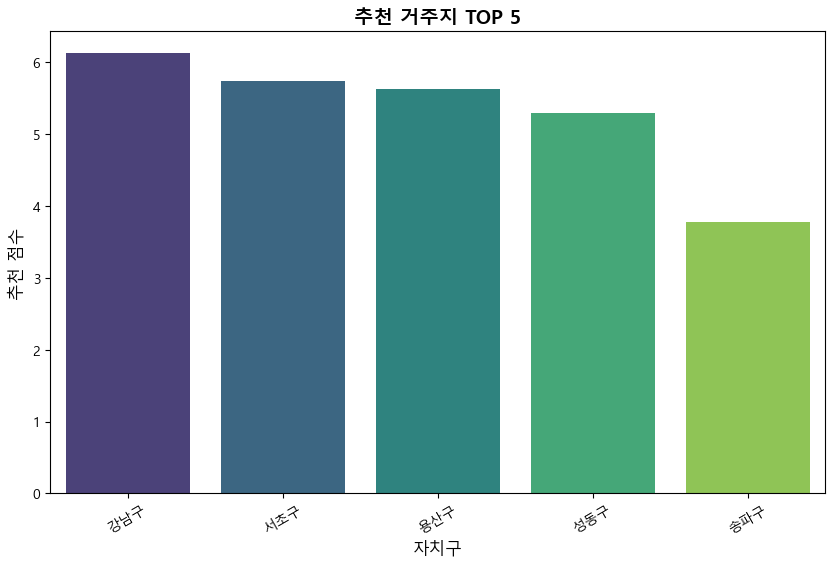

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 한글 폰트 설정
plt.rc("font", family="Malgun Gothic")

# 🔹 차트 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x="자치구", y="추천 점수", data=best_places, palette="viridis")

plt.title("추천 거주지 TOP 5", fontsize=14, fontweight="bold")
plt.xlabel("자치구", fontsize=12)
plt.ylabel("추천 점수", fontsize=12)
plt.xticks(rotation=30)
plt.show()


✅ **서울시 지도 시각화 (Folium)**

In [74]:
# 서울시 각 구의 중심 좌표 (출처: 서울 열린데이터광장)
geo_data = {
    "자치구": ["종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구",
             "성북구", "강북구", "도봉구", "노원구", "은평구", "서대문구", "마포구",
             "양천구", "강서구", "구로구", "금천구", "영등포구", "동작구", "관악구",
             "서초구", "강남구", "송파구", "강동구"],
    "위도": [37.5733, 37.5636, 37.5326, 37.5507, 37.5384, 37.5744, 37.5980,
           37.6069, 37.6396, 37.6688, 37.6542, 37.6176, 37.5792, 37.5663,
           37.5244, 37.5509, 37.4924, 37.4569, 37.5263, 37.4967, 37.4784,
           37.4836, 37.5172, 37.5113, 37.5301],
    "경도": [126.9784, 126.9978, 126.9906, 127.0413, 127.0822, 127.0384, 127.0762,
           127.0209, 127.0257, 127.0471, 127.0568, 126.9227, 126.9357, 126.9019,
           126.8563, 126.8495, 126.8874, 126.8950, 126.8963, 126.9445, 126.9516,
           127.0324, 127.0473, 127.1250, 127.1238]
}

# 데이터프레임 변환
geo_df = pd.DataFrame(geo_data)

# 기존 데이터(`merged_data`)에 위도, 경도 추가
merged_data = merged_data.merge(geo_df, on="자치구", how="left")


📌  **Folium 지도 시각화의 목적**
- 서울시 지도에서 각 자치구별로 "위험도"에 따라 원(circle marker)으로 시각화하여,
어느 지역이 상대적으로 범죄 발생률이 높고 CCTV가 부족한지 한눈에 확인 가능

In [ ]:
import folium

# 서울 지도 생성
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 🔹 위험도가 가장 높은 5개, 가장 낮은 5개 찾기
top_5 = merged_data.nlargest(5, "위험도")  # 위험도 높은 5개
bottom_5 = merged_data.nsmallest(5, "위험도")  # 위험도 낮은 5개

# 🔹 지도에 원 추가
for idx, row in merged_data.iterrows():
    # 🔹 위험도가 가장 높은 5개는 빨간색
    if row["자치구"] in top_5["자치구"].values:
        color = "red"
        fill_color = "red"
    # 🔹 위험도가 가장 낮은 5개는 초록색
    elif row["자치구"] in bottom_5["자치구"].values:
        color = "green"
        fill_color = "green"
    # 🔹 나머지는 파란색
    else:
        color = "blue"
        fill_color = "blue"
    
    # 지도에 원 추가
    folium.CircleMarker(
        location=[row["위도"], row["경도"]],  # 위도, 경도 값 필요
        radius=5 + row["위험도"] * 10,  # 크기 조절
        popup=f"{row['자치구']}<br>위험도: {row['위험도']:.2f}",
        color=color,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.6
    ).add_to(seoul_map)

#추가 설명 html
legend_html = '''
<div style="
    position: fixed;
    bottom: 50px;
    right: 20px;
    width: 160px;
    background-color: white;
    z-index:9999;
    padding: 10px;
    border-radius: 10px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
    font-size: 12px;
">
    <b>🔹 지도 범례</b><br>
    <i class="fa fa-circle" style="color:red"></i> 위험도 높은 5개 지역<br>
    <i class="fa fa-circle" style="color:blue"></i> 일반 지역<br>
    <i class="fa fa-circle" style="color:green"></i> 위험도 낮은 5개 지역
</div>
'''

# 🔹 지도에 HTML 범례 추가
seoul_map.get_root().html.add_child(folium.Element(legend_html))

# HTML 파일로 저장하여 확인 가능
seoul_map.save("seoul_risk_map.html")

print("✅ 지도 저장 완료! 'seoul_risk_map.html'을 열어보세요.")


✅ 지도 저장 완료! 'seoul_risk_map.html'을 열어보세요.


### 4️⃣ 머신러닝을 활용한 범죄 예측

### 🔢 범죄 발생 예측 모델링  

1️⃣ **데이터 준비** → X: CCTV 개수, 부동산 가격 / y: 총범죄발생  
2️⃣ **데이터 분리** → 80% 학습 / 20% 테스트  
3️⃣ **모델 학습** → RandomForestRegressor 사용  
4️⃣ **예측 수행** → model.predict()  
5️⃣ **성능 평가** → 평균 절대 오차(MAE) 계산  

-> CCTV 개수와 평균 부동산 거래 금액을 바탕으로, 해당 지역의 범죄 발생 건수를 예측하는 것이 목표

* 필요한 라이브러리 설치

In [76]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, classification_report

In [77]:
# 🔹 입력 데이터 설정
X = merged_data[["CCTV_총계", "평균거래금액"]]
y = merged_data["범죄_합계"]

# 🔹 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# 🔹 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔹 예측 및 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# 🔹 위험도 통계 계산
위험도_평균 = merged_data["위험도"].mean()
위험도_최소 = merged_data["위험도"].min()
위험도_최대 = merged_data["위험도"].max()
위험도_표준편차 = merged_data["위험도"].std()

# 🔹 테스트 데이터의 자치구 정보 가져오기
X_test_with_names = X_test.copy()
X_test_with_names["자치구"] = merged_data.loc[X_test.index, "자치구"]

# 🔹 예측 결과를 DataFrame으로 변환
result_df = pd.DataFrame({
    "자치구": X_test_with_names["자치구"],  # 자치구 이름 추가
    "실제 범죄 발생": y_test.values,  # 실제 범죄 발생 수
    "예측 범죄 발생": y_pred  # 예측한 범죄 발생 수
})

# 🔹 오차(절대값) 추가
result_df["오차(절대값)"] = abs(result_df["실제 범죄 발생"] - result_df["예측 범죄 발생"])

# 🔹 예측 결과를 정렬하여 출력 (오차가 큰 순서대로)
result_df = result_df.sort_values(by="오차(절대값)", ascending=False)

# 🔹 결과 출력
print("\n📌 랜덤포레스트 예측 결과 비교 (실제 vs 예측)\n")
print(result_df)  # 상위 10개 출력

# 🔹 위험도 통계 출력
print("\n🔹 위험도 분석")
print(f"✅ 전체 지역 평균 위험도: {위험도_평균:.4f}")
print(f"✅ 가장 낮은 위험도: {위험도_최소:.4f}")
print(f"✅ 가장 높은 위험도: {위험도_최대:.4f}")
print(f"✅ 위험도의 표준편차: {위험도_표준편차:.4f}")

# 🔹 모델의 평균 절대 오차(MAE) 출력
print("\n🔹 모델 평가")
print(f"✅ 평균적으로 모델의 예측값과 실제 범죄 발생 건수는 {mae:.2f}건 차이가 납니다.")
print("💡 MAE 값이 낮을수록 예측 정확도가 높습니다.")





📌 랜덤포레스트 예측 결과 비교 (실제 vs 예측)

     자치구  실제 범죄 발생  예측 범죄 발생  오차(절대값)
16   강남구      6763   3847.67  2915.33
0    성동구      2023   3910.72  1887.72
23   송파구      5223   3910.72  1312.28
11   관악구      4769   3592.12  1176.88
22   강서구      4296   3137.42  1158.58
1    성북구      2411   3568.16  1157.16
5    양천구      3019   4000.26   981.26
2   서대문구      2385   3363.08   978.08
8    도봉구      1921   2599.70   678.70
13   서초구      4522   3847.67   674.33
12   광진구      3424   4010.99   586.99
15   강동구      3398   3788.93   390.93
9    강북구      2497   2499.74     2.74

🔹 위험도 분석
✅ 전체 지역 평균 위험도: 0.7795
✅ 가장 낮은 위험도: 0.4361
✅ 가장 높은 위험도: 1.2739
✅ 위험도의 표준편차: 0.2051

🔹 모델 평가
✅ 평균적으로 모델의 예측값과 실제 범죄 발생 건수는 1069.31건 차이가 납니다.
💡 MAE 값이 낮을수록 예측 정확도가 높습니다.


#### 📌 머신러닝을 활용한 안전한 거주지 추천 모델  

- **목표**: 부동산 가격 + 범죄율을 고려한 거주지 추천  
- **모델**: RandomForest, GradientBoosting, KMeans  
- **입력 데이터 (X)**: CCTV 개수, 파출소 개수, 범죄율, 부동산 가격  
- **타겟 값 (y)**: `안전한 거주지(1)` vs `위험한 거주지(0)`  

💡 데이터 기반으로 보다 정확한 주거 지역 추천 가능!


In [78]:
merged_data

# 🔹 데이터 전처리: 안전도 점수 계산
merged_data["안전도_점수"] = merged_data["CCTV_총계"] / (merged_data["범죄_합계"] + 1)  # 0으로 나누는 오류 방지
merged_data["안전도_라벨"] = (merged_data["안전도_점수"] > merged_data["안전도_점수"].median()).astype(int)  # 1: 안전, 0: 위험

# 🔹 입력 데이터 & 타겟 변수 설정
X = merged_data[["CCTV_총계", "치안시설_합계", "평균거래금액", "범죄_합계"]]
y = merged_data["안전도_라벨"]

# 🔹 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 모델 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 🔹 예측 및 평가
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ 모델 정확도: {accuracy * 100:.2f}%")

# 🔹 새로운 데이터 예측 (예제)
new_data = pd.DataFrame({
    "CCTV_총계": [5000, 8000],  # CCTV 개수 예제
    "치안시설_합계": [10, 20],   # 파출소 개수 예제
    "평균거래금액": [80000, 150000],  # 평균 부동산 거래금액 예제
    "범죄_합계": [3000, 1000]   # 범죄 발생 수 예제
})

new_predictions = clf.predict(new_data)
new_data["예측_안전도"] = ["안전" if pred == 1 else "위험" for pred in new_predictions]

print("\n🔹 새로운 데이터 예측 결과:")
new_data


✅ 모델 정확도: 100.00%

🔹 새로운 데이터 예측 결과:


,CCTV_총계,치안시설_합계,평균거래금액,범죄_합계,예측_안전도
0,5000,10,80000,3000,위험
1,8000,20,150000,1000,위험


#### 5️⃣ 데이터 저장 (DB)

* 필요한 라이브러리 설치

In [79]:
from pymongo import MongoClient

In [80]:
# 🔹 MongoDB 연결
client = MongoClient("mongodb://localhost:27017/")
db = client["SeoulCrimeDB"]

# 📂 CSV 파일 로드
# real_estate_data = pd.read_csv("서울시 부동산 실거래가 정보(2022~2025).csv",  encoding='euc-kr')
cctv_data = pd.read_csv("서울시 자치구cctv.csv", encoding="utf-8")
crime_data = pd.read_csv("서울시 5대범죄발생.csv", encoding="utf-8", sep='\t')
police_data = pd.read_csv("서울시 경찰서 갯수.csv", encoding="utf-8")
merged_data
real_estate_grouped_data

# 🔹 기존 데이터 삭제 (테스트용, 필요 없으면 주석 처리)
db.real_estate.drop()
db.cctv.drop()
db.crime.drop()
db.police.drop()
db.merge.drop()
db.real_estate_grouped.drop()

# 🔹 CSV 데이터를 MongoDB에 저장
db.real_estate.insert_many(real_estate_data.to_dict("records"))
db.cctv.insert_many(cctv_data.to_dict("records"))
db.crime.insert_many(crime_data.to_dict("records"))
db.police.insert_many(police_data.to_dict("records"))
db.merge.insert_many(merged_data.to_dict("records"))
db.real_estate_grouped.insert_many(real_estate_grouped_data.to_dict("records"))

print("✅ CSV 데이터가 MongoDB(SeoulCrimeDB)에 저장되었습니다!")


✅ CSV 데이터가 MongoDB(SeoulCrimeDB)에 저장되었습니다!


In [84]:
# 🔹 MongoDB 연결
client = MongoClient("mongodb://localhost:27017/")
db = client["SeoulCrimeDB"]

# 🔹 저장된 컬렉션 목록 확인
collections = db.list_collection_names()
print("\n📂 MongoDB에 저장된 컬렉션 목록:")
print(collections)



📂 MongoDB에 저장된 컬렉션 목록:
['real_estate_grouped', 'real_estate', 'crime', 'merge', 'cctv', 'police']


> 데이터가 궁금하다면??

In [85]:
# 🔹 사용자 입력으로 컬렉션 선택
y = input("\n🔍 조회할 컬렉션 이름을 입력하세요: ")
# 🔹 입력한 컬렉션이 실제 존재하는지 확인 후 데이터 출력
if y in collections:
    print(f"\n📌 '{y}' 컬렉션 데이터 확인:")
    for doc in db[y].find().limit(20):  # 5개만 출력
        print(doc)
else:
    print(f"\n❌ 오류: '{y}' 컬렉션이 존재하지 않습니다. 다시 확인하세요.")


📌 'real_estate_grouped' 컬렉션 데이터 확인:
{'_id': ObjectId('67b680e038f6c15e60686b6f'), '자치구': '강남구', '평균거래금액': 175249.4274167475, '평균건물면적': 79.07603968638863, '평균건축년도': 1969.4863684167947}
{'_id': ObjectId('67b680e038f6c15e60686b70'), '자치구': '강동구', '평균거래금액': 74539.09800868639, '평균건물면적': 62.631046218143084, '평균건축년도': 1950.3345105124836}
{'_id': ObjectId('67b680e038f6c15e60686b71'), '자치구': '강북구', '평균거래금액': 36790.41371382202, '평균건물면적': 59.379246956992155, '평균건축년도': 1989.1678614905993}
{'_id': ObjectId('67b680e038f6c15e60686b72'), '자치구': '강서구', '평균거래금액': 41237.221077181755, '평균건물면적': 50.55300564083094, '평균건축년도': 2007.6909525880817}
{'_id': ObjectId('67b680e038f6c15e60686b73'), '자치구': '관악구', '평균거래금액': 48789.376776467994, '평균건물면적': 66.18123917593918, '평균건축년도': 1998.1603752759381}
{'_id': ObjectId('67b680e038f6c15e60686b74'), '자치구': '광진구', '평균거래금액': 74112.63684550744, '평균건물면적': 69.4322262443439, '평균건축년도': 1980.3903514459862}
{'_id': ObjectId('67b680e038f6c15e60686b75'), '자치구': '구로구', '평균거래금액': 43